In [ ]:
library(tidyverse)
library(data.table)
library(dplyr)

UBC_ISD <- fread("UBC-ISD.csv", encoding = "UTF-8")

In [ ]:
UBC_ISD_text <- UBC_ISD |>
select("twitter.tweet/text",'twitter.tweet/hashtags')|>
rename(text="twitter.tweet/text", hashtags='twitter.tweet/hashtags')|>
distinct() #removes retweets

In [ ]:
terms <- c('fuck', 'dirty', 'stupid', 'idiot', 'asshole', 'bastard', 'nasty', 'whore', 'slut', 'skank', 'cunt', 'bitch', 'motherfucker', 'go to hell', 'wimp', 'coward', 'moron', 'traitor', 'shut up', 'shut the fuck up', 'stfu', 'piece of shit', 'ignorant', 'clown', 'ccpvirus', 'chinese coronavirus', 'chinavirus', 'china virus', 'fuckchina', 'nukechina', 'bombchina', 'deathtochina', 'chinesevirus', 'fake lab wuhan', 'china weapon', 'china bioweapon', 'zionazi', 'Soros virus', 'blood libel', 'nwovirus', 'new world order', 'sacrifice children', 'jew world order', 'liar', 'yellow star', 'israel virus', 'israelvirus', 'rothschild covid', 'kalergi plan', 'jail', 'locked up', 'evil.', 'is evil', 'so evil', 'pure evil', 'an evil', 'evil wom', 'evil man', 'evil witch', 'is evil', 'are evil', 'that evil', 'very evil', 'tyrant', 'tyranny', 'dictator', 'tv doctor', 'twitter doctor', 'murder', 'murderer', 'eugenic', 'satan', 'Nazi', 'non-human', 'sterile', 'slave', 'crooked', 'corrupt', 'shill', 'liar', 'lying', 'killer', 'fraud', 'big pharma', 'pharma puppet', 'Nuremberg', 'crimes against humanity', 'genocide', 'child abuse', 'covid hoax', 'covid fake', 'virus hoax', 'gates virus', 'bioweapon', 'secret elite', 'depopulation', 'save our children', 'scamdemic', 'plandemic')
terms <- paste0(" ", terms)
pattern <- paste(terms, collapse = "|")

In [ ]:
UBC_ISD_text$toxicity <- ifelse(grepl(pattern, UBC_ISD_text$text, ignore.case = TRUE), 1, 0)

In [ ]:
UBC_ISD_text_hashtags <- UBC_ISD_text |>
select(hashtags, toxicity)

UBC_ISD_text_hashtags$hashtags <- gsub("^\\[|\\]$", "", UBC_ISD_text_hashtags$hashtags)
UBC_ISD_text_hashtags <-  UBC_ISD_text_hashtags|>
separate_rows(hashtags, sep = ",\\s*")

UBC_ISD_text_hashtags$hashtags <- na_if(UBC_ISD_text_hashtags$hashtags, "")

UBC_ISD_text_hashtags <-  UBC_ISD_text_hashtags|>
drop_na()
UBC_ISD_text_hashtags

In [ ]:
UBC_ISD_text_hashtags_popular <- UBC_ISD_text_hashtags|>
group_by(hashtags)|>
summarize(toxicity = sum(toxicity))|>
arrange(desc(toxicity))

In [ ]:
stance <- read_csv("cleaned_hashtags_ideology.csv")

stance_pro <- stance|>
filter(ideology=="pro")|>
select(hashtags)
stance_pro$hashtags <- sub("#", "", stance_pro$hashtags)|>
as.list()

stance_anti <- stance|>
filter(ideology=="anti")|>
select(hashtags)
stance_anti$hashtags <- sub("#", "", stance_anti$hashtags)|>
as.list()

filtered_hashtags_anti <- UBC_ISD_text_hashtags_popular|>
filter(UBC_ISD_text_hashtags_popular$hashtags %in% stance_anti$hashtags)
filtered_hashtags_anti 

filtered_hashtags_pro <- UBC_ISD_text_hashtags_popular|>
filter(UBC_ISD_text_hashtags_popular$hashtags %in% stance_pro$hashtags)
filtered_hashtags_pro

In [43]:
filtered_hashtags_anti <- UBC_ISD_text_hashtags|>
filter(UBC_ISD_text_hashtags$hashtags %in% stance_anti$hashtags)|>
nrow()

filtered_hashtags_anti_toxic <- UBC_ISD_text_hashtags|>
filter(UBC_ISD_text_hashtags$hashtags %in% stance_anti$hashtags)|>
filter(toxicity==1)|>
nrow()

filtered_hashtags_pro <- UBC_ISD_text_hashtags|>
filter(UBC_ISD_text_hashtags$hashtags %in% stance_pro$hashtags)|>
nrow()

filtered_hashtags_pro_toxic <- UBC_ISD_text_hashtags|>
filter(UBC_ISD_text_hashtags$hashtags %in% stance_pro$hashtags)|>
filter(toxicity==1)|>
nrow()

counts <- data.frame(ideology = c("pro restrictions","pro restrictions","anti restrictions","anti restrictions"),
                    type = c("total","toxic","total","toxic"),
                    count = c(filtered_hashtags_pro, filtered_hashtags_pro_toxic, filtered_hashtags_anti, filtered_hashtags_anti_toxic)
)

Saving 6.67 x 6.67 in image


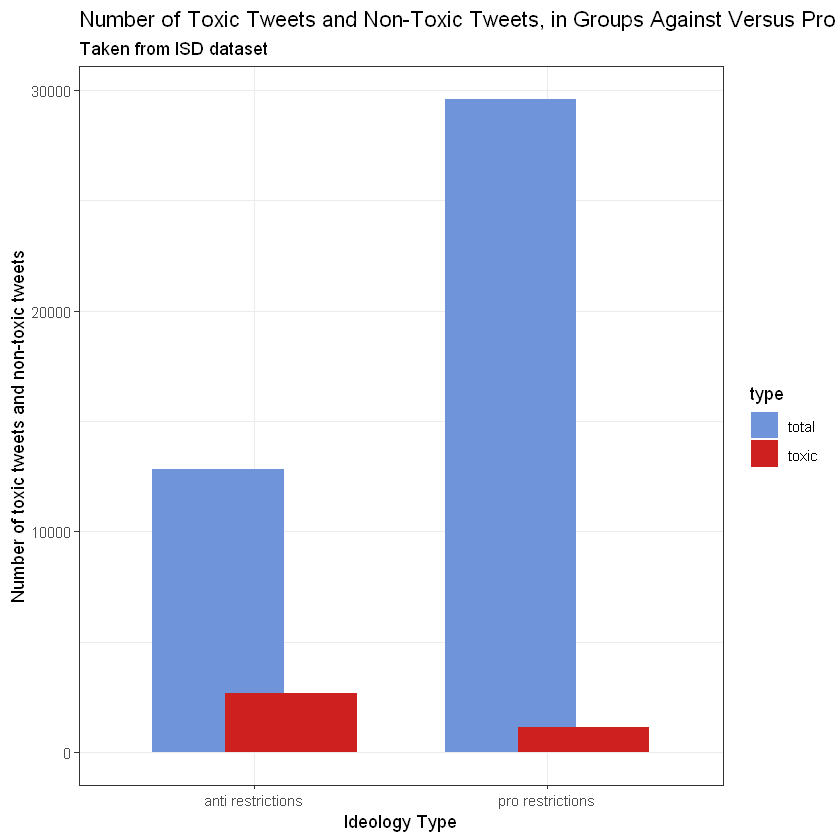

In [51]:
colors=c("#6f94d9", "#cf2020")

counts_graph <- counts|>
ggplot(aes(x=ideology, y=count, fill=type))+
geom_bar(stat="identity", position = position_dodge(width = 0.5))+
scale_fill_manual(values = colors)+
ggtitle("Number of Toxic Tweets and Non-Toxic Tweets, in Groups Against Versus Pro COVID Restrictions")+
labs(subtitle="Taken from ISD dataset", x="Ideology Type", y="Number of toxic tweets and non-toxic tweets")+
theme_bw()

counts_graph

ggsave("Hashtags_ISD.png")